# DSCI 552 Final Project
# Aanlyzing potential ratial and gender bias of COMPAS model
## Yue Hao

## Import Libraries

In [1]:
"""Import libraries"""

#pip install matplotlib,seaborn,sklearn,yellowbrick

import pandas as pd
import numpy as np
import matplotlib
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#libraries for data preprocessing
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

#Library for validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#Libraries for modeling
import statsmodels.api as sm
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

#Libraries for evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc


## 1. Data Exploration

### 1.1 COMPAS-Risk of General Recidivism

In [2]:
"""Read the csv file from specific directory"""

# Please specify your local directory
#file_path=("your_own_path")
file_path = "compas-scores-two-years.csv"
csv_data =  pd.read_csv(file_path)
two_year_data = pd.DataFrame(csv_data)
two_year_data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
#Make a copy of the raw data for data cleaning
compas_data=two_year_data.copy()

### 1.2 COMPAS-Risk of Violent  Recidivism

In [4]:
"""Read the csv file from specific directory"""

# Please specify your local directory
#file_path=("your_own_path")
file_path = "compas-scores-two-years-violent.csv"
csv_data =  pd.read_csv(file_path)
violent_data = pd.DataFrame(csv_data)
#violent_data.head()

In [5]:
"""Filter useful columns"""

compas=compas_data[["id","name","sex","race","age",
                    "decile_score","score_text","v_decile_score","v_score_text",
                    "c_charge_degree","priors_count.1","two_year_recid"]]

In [6]:
compas_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

## 2. Data visualizations

### 2.1 Potential racial bias behind COMPAS scores

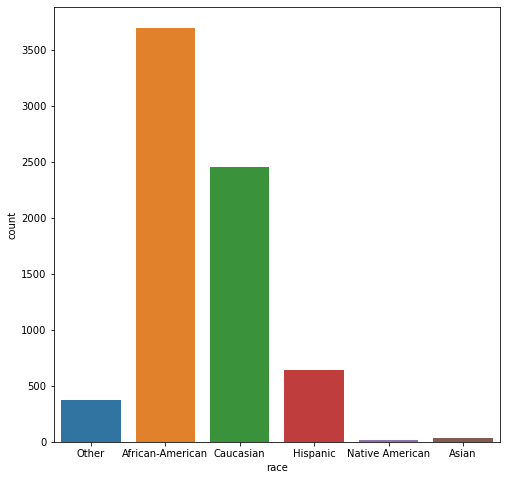

In [7]:
"""Counts of defendants"""

plt.figure(figsize=(8, 8))
sns.countplot(x='race',data=compas)
plt.show()

In [137]:
compas.loc[:,'race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

In [124]:
"""Calculate racial proportion"""
data=pd.crosstab(compas.decile_score,compas.race)
data=data.div(data.sum(1).astype(float), axis=0)
data=data.round(4)

In [125]:
data

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,0.2764,0.0104,0.4729,0.1361,0.0000,0.1042
2,0.4176,0.0043,0.3836,0.1201,0.0043,0.0701
3,0.4632,0.0067,0.3655,0.1151,0.0013,0.0482
4,0.5007,0.0000,0.3706,0.0676,0.0013,0.0598
5,0.5360,0.0015,0.3539,0.0764,0.0000,0.0323
6,0.5991,0.0047,0.3027,0.0577,0.0031,0.0328
7,0.6757,0.0017,0.2416,0.0574,0.0068,0.0169
8,0.7012,0.0039,0.2227,0.0508,0.0020,0.0195
9,0.7480,0.0000,0.1929,0.0394,0.0039,0.0157


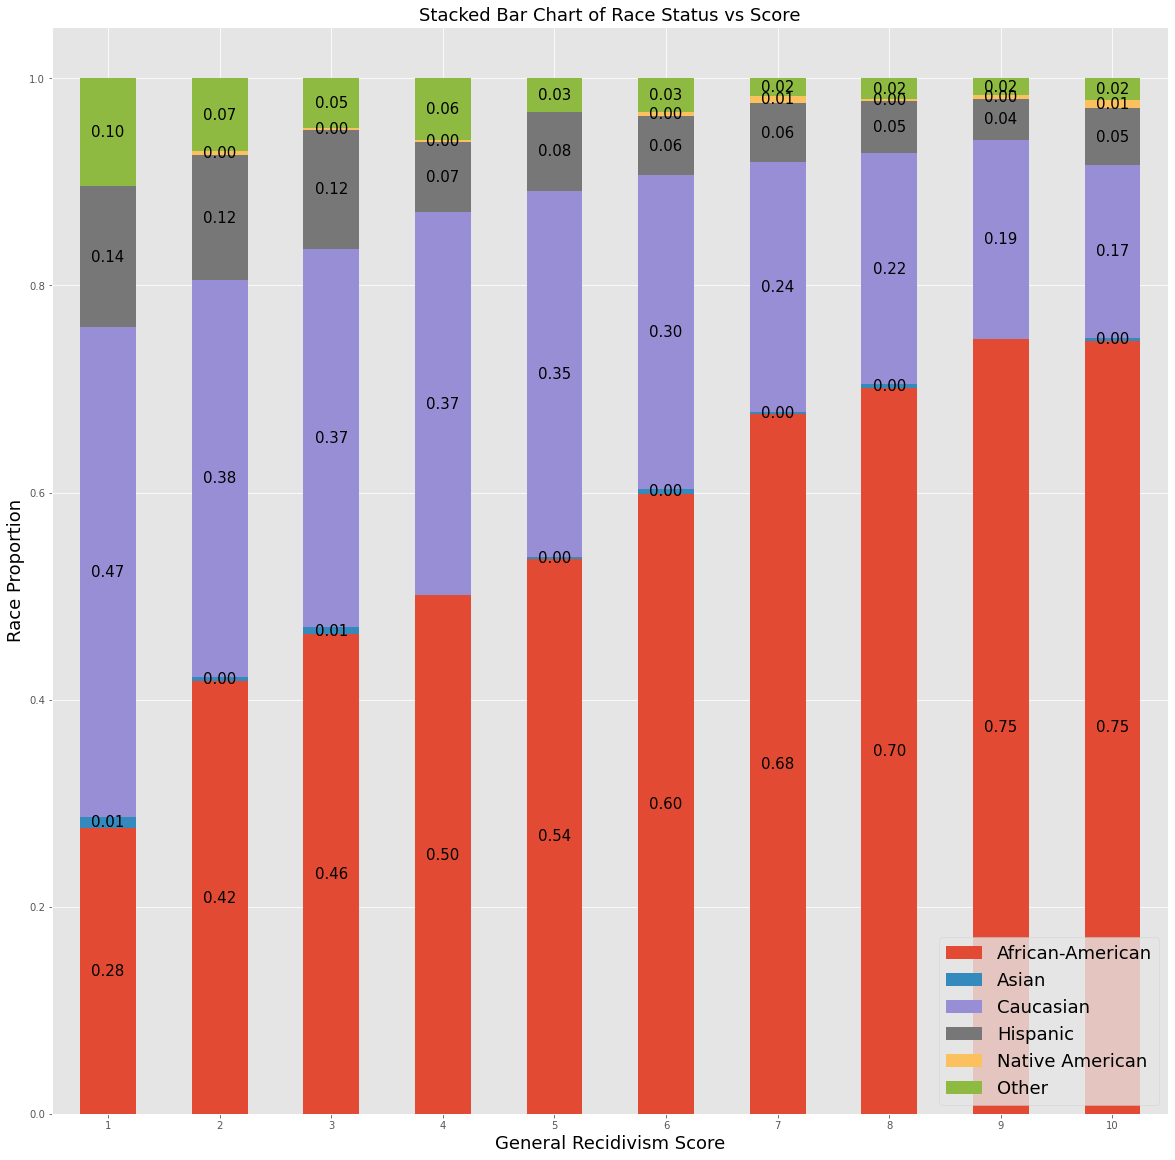

In [121]:
"""Plot racial proportion of decile COMPAS Score"""

# hints:https://stackoverflow.com/questions/41296313/stacked-bar-chart-with-centered-labels

plt.style.use('ggplot')

data=pd.crosstab(compas.decile_score,compas.race)
data=data.div(data.sum(1).astype(float), axis=0)
#data=data*100
#data=data.round()
#data=pd.crosstab(compas.decile_score,compas.race)
ax = data.plot(stacked=True, kind='bar', figsize=(20, 20), rot='horizontal')

# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.2f}'  # f'{height:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2

    # plot only when height is greater than specified value
    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=15)
plt.title('Stacked Bar Chart of Race Status vs Score',fontsize=18)    
ax.legend(loc='lower right',fontsize=18)    
ax.set_ylabel("Race Proportion", fontsize=18,color="black")
ax.set_xlabel("General Recidivism Score", fontsize=18,color="black")
plt.show()

### 2.2 Actual recidivism risk  vs. COMPAS precitions

<font color=darkblue size=4 face=Arial>
    
In this analysis, the actual recidivism risk is defined as a new arrest within two years and vice versa. To be more specific, 0 stands for low risk while 1 stands for high risk.
As to the COMPAS data set, scores of “Low” indicate no or low risk of recidivism (0), while "Medium" or "High" indicate a risk (1).
    
</font>

<ipython-input-122-04cac2ca120d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compas["risk"] = np.where(compas["score_text"]=="Low" ,0,1)


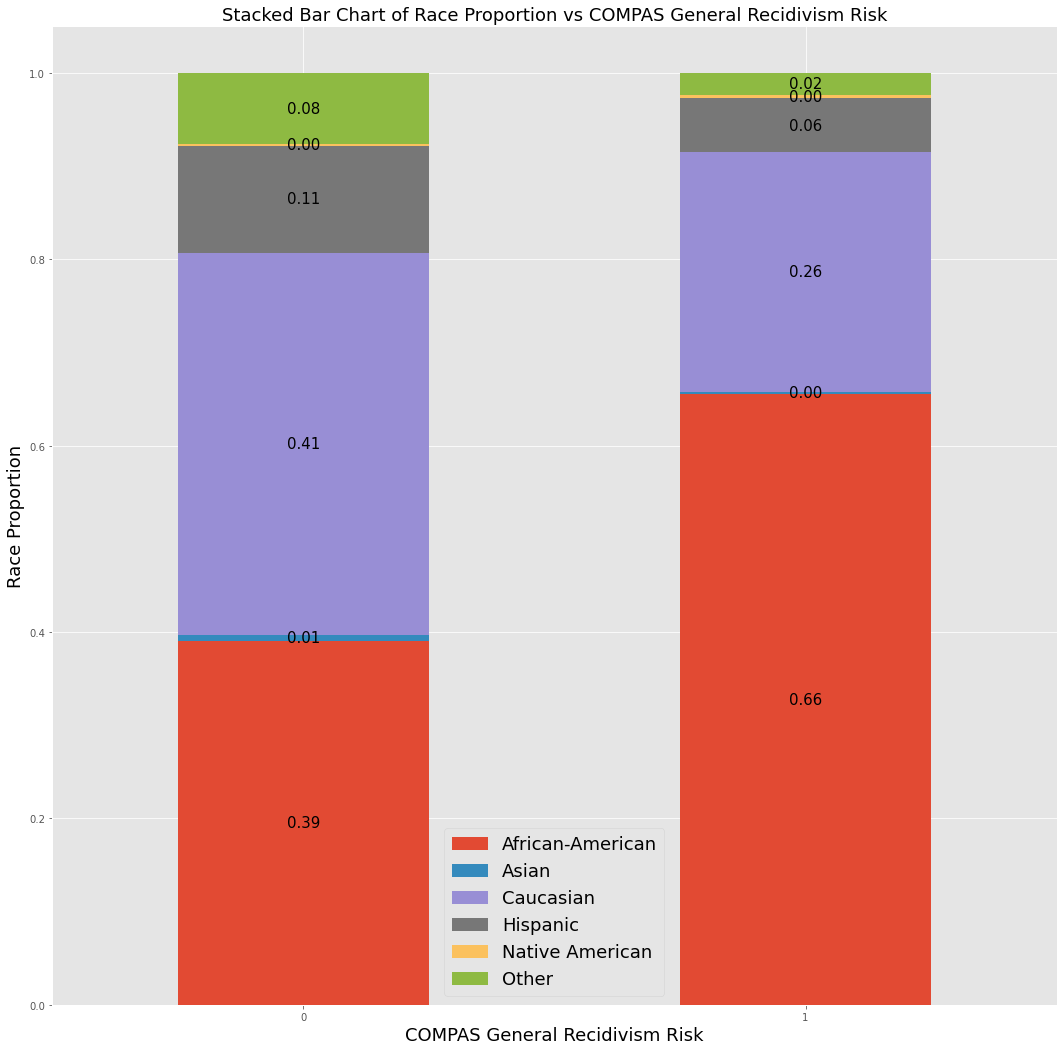

In [122]:
"""Plot racial proportion of recidivism risk based on COMPAS Score"""

plt.style.use('ggplot')


compas["risk"] = np.where(compas["score_text"]=="Low" ,0,1)
data=pd.crosstab(compas.risk,compas.race)
data=data.div(data.sum(1).astype(float), axis=0)
ax = data.plot(stacked=True, kind='bar', figsize=(18, 18), rot='horizontal')

# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.2f}'  # f'{height:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2

    # plot only when height is greater than specified value
    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=15)
plt.title('Stacked Bar Chart of Race Proportion vs COMPAS General Recidivism Risk',fontsize=18)    
ax.legend(loc='best',fontsize=18)    
ax.set_ylabel("Race Proportion", fontsize=18,color="black")
ax.set_xlabel("COMPAS General Recidivism Risk", fontsize=18,color="black")
plt.show()

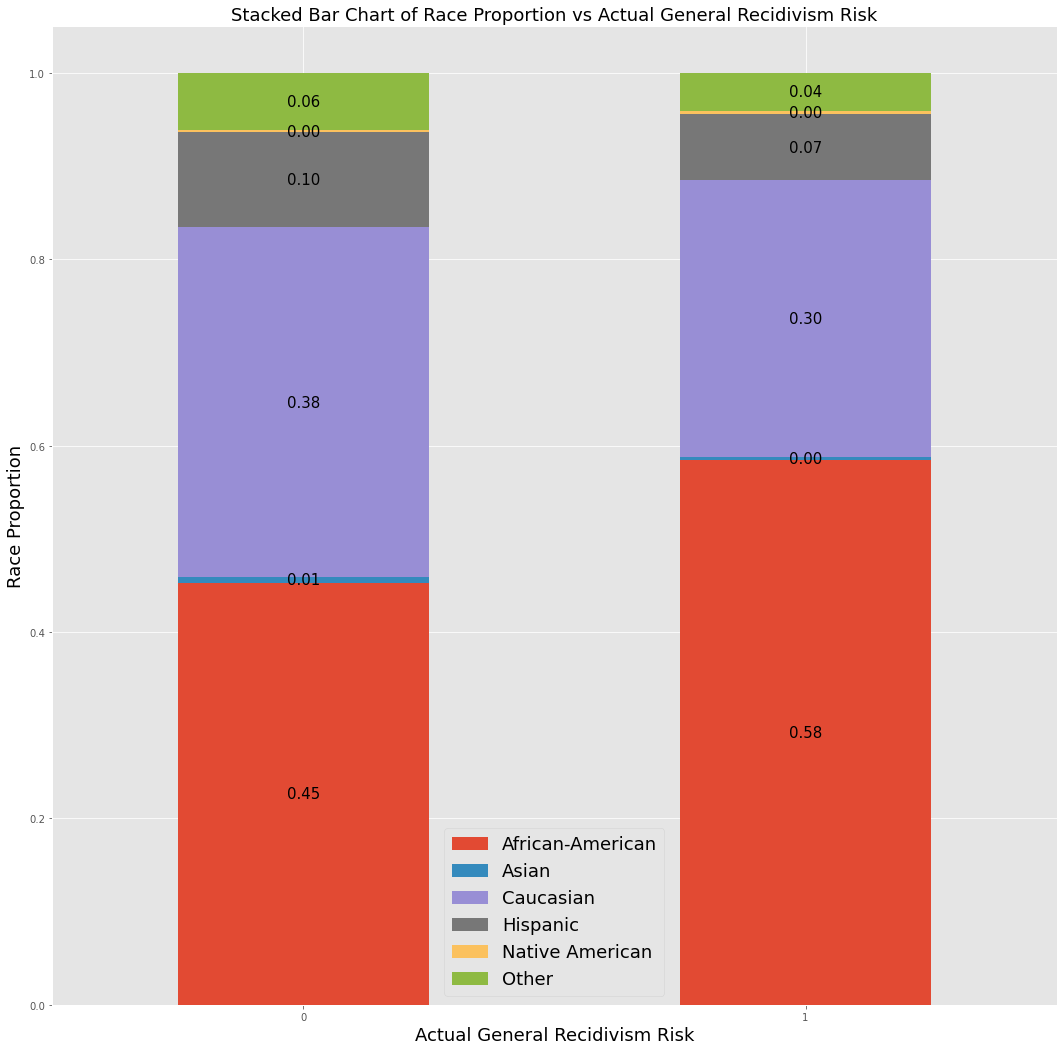

In [123]:
"""Plot racial proportion of recidivism risk based on actual criminal records"""

plt.style.use('ggplot')

data=pd.crosstab(compas.two_year_recid,compas.race)
data=data.div(data.sum(1).astype(float), axis=0)

ax = data.plot(stacked=True, kind='bar', figsize=(18, 18), rot='horizontal')

# .patches is everything inside of the chart
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    # The height of the bar is the data value and can be used as the label
    label_text = f'{height:.2f}'  # f'{height:.2f}' to format decimal values
    
    # ax.text(x, y, text)
    label_x = x + width / 2
    label_y = y + height / 2

    # plot only when height is greater than specified value
    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=15)
plt.title('Stacked Bar Chart of Race Proportion vs Actual General Recidivism Risk',fontsize=18)    
ax.legend(loc='best',fontsize=18)    
ax.set_ylabel("Race Proportion", fontsize=18,color="black")
ax.set_xlabel("Actual General Recidivism Risk", fontsize=18,color="black")
plt.show()

## 3. Logistic Regression Model 

In [130]:
"""Feature engineering"""

norm = StandardScaler()
data=compas_data.copy()
data=data[["two_year_recid","sex","race","c_charge_degree","priors_count","age","event"]] 
data=pd.get_dummies(data, columns=["sex","race","c_charge_degree","event"])
data['age'] = norm.fit_transform(np.array(data['age']).reshape(-1,1))

In [149]:
data

,two_year_recid,sex_Female,sex_Male,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,age_cat_25 - 45,...,priors_count_29,priors_count_30,priors_count_31,priors_count_33,priors_count_35,priors_count_36,priors_count_37,priors_count_38,is_recid_0,is_recid_1
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7210,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7211,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7212,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [131]:
"""Split prepared dataset into training dataset and test dataset """

X_train, X_test, y_train, y_test = train_test_split(
    data.iloc[:,1:], data["two_year_recid"], test_size=0.20, random_state=1)

In [132]:
"""15-folds cross validation"""
"""Logistic model (default: L2 regularization)"""

kfold = model_selection.KFold(n_splits=15)
logreg = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(logreg, X_train, y_train, cv=kfold, scoring=scoring)


In [133]:
print(f"Comparison of cross validation average accuracy:{(results.mean())} ")

Comparison of cross validation average accuracy:0.8946424062049062 


<font color=darkblue size=4 face=Arial>
    
Based on the cross validation result, the logistic regression model has an accuracy around 0.9.
</font>

## 4. Model Evaluation 

### 4.1 Use ROC curve 

In [134]:
"""Fit the model"""
logreg.fit(X_train, y_train)

LogisticRegression()

<Figure size 432x288 with 0 Axes>

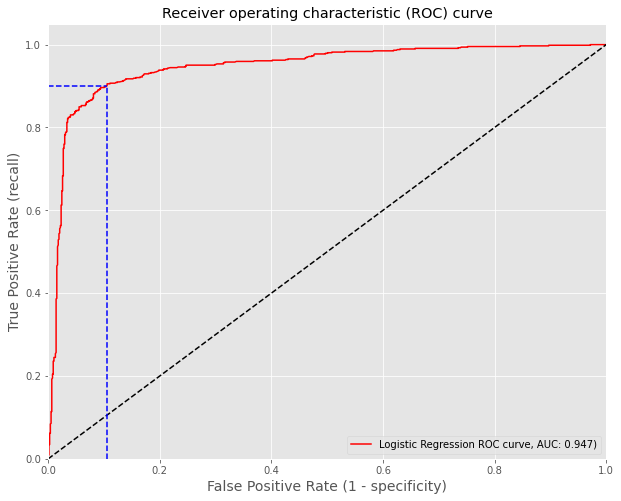

Summary:
Accuracy: 0.900
AUC: 0.947
Tthreshold: 0.217 
Sensitivity of 0.901 
False Positive Rate: 10.55%.


In [106]:
"""Plot ROC and determine AUC"""

# logreg3: Elastic Net regularization was used

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

# index of the first threshold for which the sensibility > 0.90
idx = np.min(np.where(tpr > 0.90)) 

plt.figure()
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='Red', 
         label='Logistic Regression ROC curve, AUC: %0.3f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Summary:")
print("Accuracy: %2.3f" % accuracy_score(y_test, y_pred))
print("AUC: %2.3f" % auc(fpr, tpr))
print("Tthreshold: %.3f " % thr[idx])
print("Sensitivity of %.3f " % tpr[idx])
print( "False Positive Rate: %.2f%%." % (np.array(fpr[idx])*100))

### 4.2 Classification Matrix

In [109]:
"""Classification Marix"""

#hints: https://www.kaggle.com/prashant111/logistic-regression-classifier-tutorial#15.-Confusion-matrix-
y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       777
           1       0.95      0.83      0.88       666

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.90      0.90      0.90      1443



### 4.3 Check coefficients

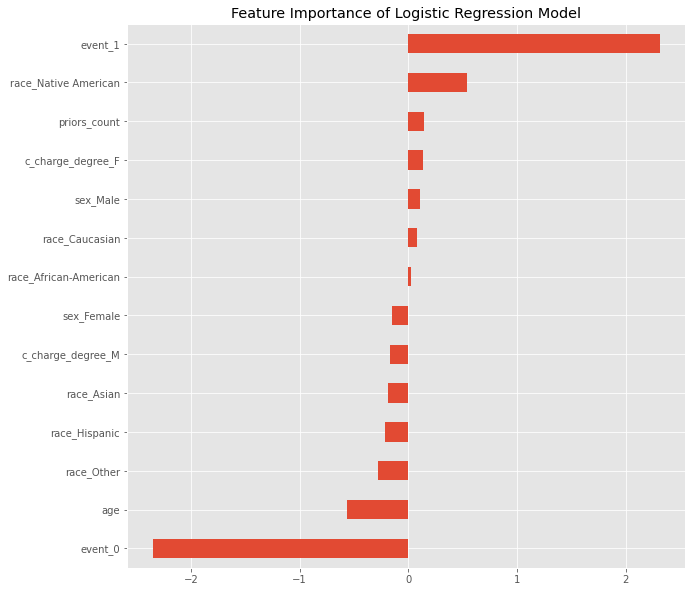

In [135]:
"""Visualize feature coefficients"""

coef = pd.Series(np.transpose(logreg.coef_.tolist()[0]), index = X_train.columns)
coef = coef.sort_values()
coef.plot(kind = "barh",figsize=(10,10))
plt.title("Feature Importance of Logistic Regression Model")
plt.show()

In [38]:
coef

event_0                 -2.281224
age                     -0.563626
c_charge_degree_M       -0.298651
race_Other              -0.261115
race_Hispanic           -0.211452
sex_Female              -0.150907
race_African-American    0.000000
race_Asian               0.000000
c_charge_degree_F        0.000000
race_Caucasian           0.052152
sex_Male                 0.089298
priors_count             0.147527
race_Native American     0.251882
event_1                  2.394292
dtype: float64